# Part2a

(a): You should implement a distance-weighted variant of the k-NN algorithm you
developed in part 1. In your report include the performance achieved by the distanceweighted k-NN for k=10. 

In [14]:
import numpy as np
import statistics as stat
import matplotlib.pyplot as plt

class MLPart2a:
    def __init__(self, __trainingDataFile, __testDataFile, __k):
      
        self.trainingDataFileName = __trainingDataFile
        self.testDataFileName = __testDataFile
        self.trainingData = np.array([])
        self.testData = np.array([])
        self.euclideanDistances = np.array([])
        self.euclideanDistancesSorted = np.array([])
        self.predictions = np.array([])
        self.originalCategories = np.array([])
        self.readInstances()
        self.k = __k

    def readInstances(self):
        """
        Reading an instance from fName
        """
        self.trainingData = np.genfromtxt(self.trainingDataFileName, delimiter=',', dtype=float)
        self.testData = np.genfromtxt(self.testDataFileName, delimiter=',', dtype=float)
        self.originalCategories = self.testData[:, -1]

    # Works on local variables and returns 2 numpy array
    def calculateDistances(self,trainingInstancesMatrix, singlQueryPoint):
        data = np.sqrt(np.sum((trainingInstancesMatrix - singlQueryPoint) ** 2, axis=1))
        return data, np.argsort(data)

    # Works on global variables
    def updateDistances(self):
         distances = []
         sortedDistances = []
         for i in range(0, np.shape(self.testData)[0]):
            d, sd = self.calculateDistances(self.trainingData[:, :-1], self.testData[i, :-1])
            distances.append(d)
            sortedDistances.append(sd)
            i+= 1
         self.euclideanDistances = np.array(distances)
         self.euclideanDistancesSorted = np.array(sortedDistances)

    def predictCategories(self):
        prediction = np.array([])
        # To order to improve performance, avoid calculation with K=1
        if self.k == 1:
            for i in range(0, len(self.euclideanDistances)):
                index = self.euclideanDistancesSorted[i][0]
                prediction = np.append(prediction, self.trainingData[index][-1])
        else:
            for i in range(0, len(self.euclideanDistances)):
                indices = self.euclideanDistancesSorted[i, :self.k]
                indice_category_distance = {}
                for indice in indices:
                    indice_category_distance[indice] = [self.trainingData[indice][-1], self.euclideanDistances[i][indice]]
                cat_0_values = np.array([])
                cat_1_values = np.array([])
                cat_2_values = np.array([])

                for indice_values in indice_category_distance.values():
                    if int(indice_values[0]) == 0:
                        cat_0_values = np.append(cat_0_values, 1/indice_values[1])
                    elif int(indice_values[0]) == 1:
                        cat_1_values = np.append(cat_1_values, 1/indice_values[1])
                    else:
                        cat_2_values = np.append(cat_2_values, 1/indice_values[1])
                cat0 = 0
                cat1 = 0
                cat2 = 0
                if len(cat_0_values) != 0:
                    cat0 = np.sum(cat_0_values)
                if len(cat_1_values) != 0:
                    cat1 = np.sum(cat_1_values)
                if len(cat_2_values) != 0:
                    cat2 = np.sum(cat_2_values)

                cat = np.where([cat0, cat1, cat2] == np.max([cat0, cat1, cat2]))

                if cat[0][0] == 0:
                    prediction = np.append(prediction, 0.0)
                elif cat[0][0] == 1:
                    prediction = np.append(prediction, 1.0)
                else:
                    prediction = np.append(prediction, 2.0)
        self.predictions = prediction

    def predictionAccuracy(self):
        instancesCount = len(self.originalCategories)
        correctPredictionCounter = 0
        for i in range(0,instancesCount):
            if int(self.originalCategories[i]) == int(self.predictions[i]):
                correctPredictionCounter += 1
        return (correctPredictionCounter/instancesCount) * 100

    def search(self):
        self.updateDistances()
        self.predictCategories()
        return self.predictionAccuracy()


    
prediction_over_k = np.array([])   
K = np.array([])
for i in range(1,11):
    ml = MLPart2a("data\\classification\\trainingData.csv", "data\\classification\\testData.csv", i)
    tmp = ml.search()
    print("Prediction accuracy is {} for K = {} ".format(tmp,i))
    K = np.append(K,i)
    prediction_over_k = np.append(prediction_over_k, tmp)

plt.xlabel("Value of K")
plt.ylabel("Accuracy prediction")
plt.title("Part 2a - Graph")
plt.plot(K,prediction_over_k)
plt.show()




Prediction accuracy is 89.5 for K = 1 
Prediction accuracy is 89.5 for K = 2 
Prediction accuracy is 91.3 for K = 3 
Prediction accuracy is 92.10000000000001 for K = 4 
Prediction accuracy is 92.4 for K = 5 
Prediction accuracy is 92.4 for K = 6 
Prediction accuracy is 92.4 for K = 7 
Prediction accuracy is 92.60000000000001 for K = 8 
Prediction accuracy is 93.0 for K = 9 
Prediction accuracy is 92.7 for K = 10 


<Figure size 640x480 with 1 Axes>

# Part2b

(b) There are a range of different techniques you can investigate that could potentially improve the performance of either the distance-weighted k-NN and the basic k-NN from part 1. 

For example, you could look at the performance of these algorithms for different hyper-parameter settings (such as the value of k).
You should describe and investigate a comprehensive range of techniques that could potentially improve the accuracy of your basic k-NN and distance-weighted k-NN. Your report should document fully the different techniques, provide a justification for selecting and investigating these techniques and present the resulting accuracy.

Please note that when you incorporate additional techniques you should implement these techniques in your own code using core Python or NumPy (rather than relying on imported functionality or high level functions).

The recommended length of the report section is 4 pages (this is just a recommendation and you will not be penalized if you exceed the 4 pages). 

In [15]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

class MLPart2a:
    def __init__(self, __trainingDataFile, __testDataFile, __k, __distance_weighted=True, __distance_measurements_method= "Euclidean", __weight_power = 1):
        self.trainingDataFileName = __trainingDataFile
        self.testDataFileName = __testDataFile
        self.trainingData = np.array([])
        self.testData = np.array([])
        self.distances = np.array([])
        self.distancesSorted = np.array([])
        self.predictions = np.array([])
        self.originalCategories = np.array([])
        self.readInstances()
        self.distance_weighted = __distance_weighted
        self.k = __k
        self.distance_measurements_method = __distance_measurements_method.lower()
        self.weight_power = __weight_power

    def readInstances(self):
        """
        Reading an instance from fName
        """
        self.trainingData = np.genfromtxt(self.trainingDataFileName, delimiter=',', dtype=float)
        self.testData = np.genfromtxt(self.testDataFileName, delimiter=',', dtype=float)
        self.originalCategories = self.testData[:, -1]

    # Works on local variables and returns 2 numpy array
    def calculateDistancesEuclidean(self,trainingInstancesMatrix, singlQueryPoint):
        data = np.sqrt(np.sum((trainingInstancesMatrix - singlQueryPoint) ** 2, axis=1))
        return data, np.argsort(data)

    # Works on global variables
    def updateDistancesEuclidean(self):
         distances = []
         sortedDistances = []
         for i in range(0, np.shape(self.testData)[0]):
            d, sd = self.calculateDistancesEuclidean(self.trainingData[:, :-1], self.testData[i, :-1])
            distances.append(d)
            sortedDistances.append(sd)
            i+= 1
         self.distances = np.array(distances)
         self.distancesSorted = np.array(sortedDistances)

         # Works on local variables and returns 2 numpy array

    def calculateDistancesManhattan(self, trainingInstancesMatrix, singlQueryPoint):
        data = np.sum(np.absolute(trainingInstancesMatrix - singlQueryPoint), axis=1)
        return data, np.argsort(data)

        # Works on global variables

    def updateDistancesManhattan(self):
        distances = []
        sortedDistances = []
        for i in range(0, np.shape(self.testData)[0]):
            d, sd = self.calculateDistancesManhattan(self.trainingData[:, :-1], self.testData[i, :-1])
            distances.append(d)
            sortedDistances.append(sd)
            i += 1
        self.distances = np.array(distances)
        self.distancesSorted = np.array(sortedDistances)
    def predictCategoriesBasic(self):
        prediction = np.array([])
        # To order tp improve performance, avoid calculation with K=1
        if self.k == 1:
            for i in range(0, len(self.distances)):
                index = self.distancesSorted[i][0]
                prediction = np.append(prediction, self.trainingData[index][-1])
        else:
            for i in range(0, len(self.distances)):
                indices = self.distancesSorted[i, :self.k]
                tie = []
                for indice in indices:
                    tie.append(self.trainingData[indice][-1])
                data = Counter(tie)
                #print(data.most_common(1)[0][0])  # Returns the highest occurring item
                prediction = np.append(prediction, data.most_common(1)[0][0])
        self.predictions = prediction
        
    


    def predictCategoriesWeighted(self):
        prediction = np.array([])
        # To order to improve performance, avoid calculation with K=1
        if self.k == 1:
            for i in range(0, len(self.distances)):
                index = self.distancesSorted[i][0]
                prediction = np.append(prediction, self.trainingData[index][-1])
        else:
            for i in range(0, len(self.distances)):
                indices = self.distancesSorted[i, :self.k]
                indice_category_distance = {}
                for indice in indices:
                    indice_category_distance[indice] = [self.trainingData[indice][-1], self.distances[i][indice]]
                cat_0_values = np.array([])
                cat_1_values = np.array([])
                cat_2_values = np.array([])

                for indice_values in indice_category_distance.values():
                    if int(indice_values[0]) == 0:
                        cat_0_values = np.append(cat_0_values, 1/np.power(indice_values[1], self.weight_power))
                    elif int(indice_values[0]) == 1:
                        cat_1_values = np.append(cat_1_values, 1/np.power(indice_values[1], self.weight_power))
                    else:
                        cat_2_values = np.append(cat_2_values, 1/np.power(indice_values[1], self.weight_power))
                cat0 = 0
                cat1 = 0
                cat2 = 0
                if len(cat_0_values) != 0:
                    cat0 = np.sum(cat_0_values)
                if len(cat_1_values) != 0:
                    cat1 = np.sum(cat_1_values)
                if len(cat_2_values) != 0:
                    cat2 = np.sum(cat_2_values)

                cat = np.where([cat0, cat1, cat2] == np.max([cat0, cat1, cat2]))

                if cat[0][0] == 0:
                    prediction = np.append(prediction, 0.0)
                elif cat[0][0] == 1:
                    prediction = np.append(prediction, 1.0)
                else:
                    prediction = np.append(prediction, 2.0)
        self.predictions = prediction

    def predictionAccuracy(self):
        instancesCount = len(self.originalCategories)
        correctPredictionCounter = 0
        for i in range(0,instancesCount):
            if int(self.originalCategories[i]) == int(self.predictions[i]):
                correctPredictionCounter += 1
        return (correctPredictionCounter/instancesCount) * 100

    def search(self):
        if self.distance_measurements_method == "euclidean":
            self.updateDistancesEuclidean()
        else:
            self.updateDistancesManhattan()

        if self.distance_weighted:
            self.predictCategoriesWeighted()
        else:
            self.predictCategoriesBasic()
        config = {"K":self.k, "weighted_distance":self.distance_weighted, "distance_calcuation_method":self.distance_measurements_method, "weight_power":self.weight_power}
        return [self.predictionAccuracy(), config ]

#Euclidean, Manhattan




# Hyper parameter for the program

<h4>Contructor signiture</h4>

 def __init__(self, __trainingDataFile, __testDataFile, __k, __distance_weighted=True, __distance_measurements_method= "Euclidean", __weight_power = 1):

<h4>Contructor parameter distriction</h4>

__trainingDataFile : path for training data file
__testDataFile : path for test data file
__k : value of K
__distanceweighted : Use distance weighted calculation (Default: True) 
__distancemeasurements_method : Which method to use for distance calculation, Euclidean or Manhattan (Default: Euclidean)
__weightpower : Value to weight power (Used in predictCategoriesWeighted method)

# Comparision:  Basic euclidean distance vs Weighted euclidean distance

Prediction accuracy based on basic distance for K= 1 is 89.5: 
Prediction accuracy based on weight distance for K= 1 is 89.5: 
Prediction accuracy based on basic distance for K= 2 is 89.5: 
Prediction accuracy based on weight distance for K= 2 is 89.5: 
Prediction accuracy based on basic distance for K= 3 is 91.3: 
Prediction accuracy based on weight distance for K= 3 is 91.3: 
Prediction accuracy based on basic distance for K= 4 is 91.9: 
Prediction accuracy based on weight distance for K= 4 is 92.10000000000001: 
Prediction accuracy based on basic distance for K= 5 is 92.4: 
Prediction accuracy based on weight distance for K= 5 is 92.4: 
Prediction accuracy based on basic distance for K= 6 is 92.5: 
Prediction accuracy based on weight distance for K= 6 is 92.4: 
Prediction accuracy based on basic distance for K= 7 is 92.30000000000001: 
Prediction accuracy based on weight distance for K= 7 is 92.4: 
Prediction accuracy based on basic distance for K= 8 is 92.7: 
Prediction accuracy ba

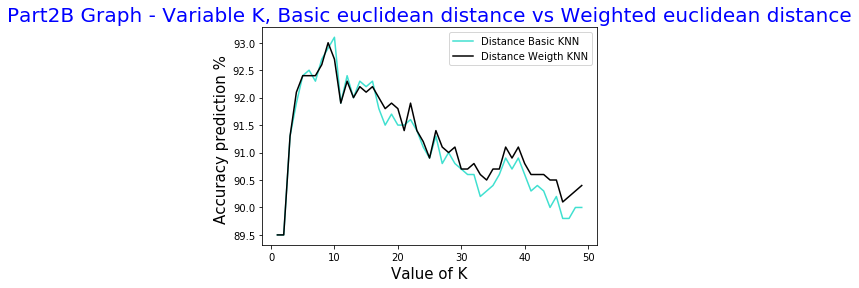

In [27]:




values_based_on_basic_distances = np.array([])
values_based_on_wighted_distances = np.array([])
K_values = np.array([])
for k in range(1,50):
    ml_basic_distance = MLPart2a("data\\classification\\trainingData.csv", "data\\classification\\testData.csv", k, False, "Euclidean", 1)
    [prediction, configuration] = ml_basic_distance.search()
    values_based_on_basic_distances = np.append(values_based_on_basic_distances, prediction)
    K_values = np.append(K_values,k)
    print("Prediction accuracy based on basic distance for K= {} is {}: ".format(k,prediction))
    
    ml_weighted_distance = MLPart2a("data\\classification\\trainingData.csv", "data\\classification\\testData.csv", k, True, "Euclidean", 1)
    [prediction, configuration] = ml_weighted_distance.search()
    values_based_on_wighted_distances = np.append(values_based_on_wighted_distances, prediction)
    print("Prediction accuracy based on weight distance for K= {} is {}: ".format(k,prediction))
    

print("*********************************************************************")
print("Distance calculation method: {} | Weight Power: {}".format(configuration['distance_calcuation_method'],configuration['weight_power']))
print("*********************************************************************")
plt.xlabel("Value of K",fontsize=15)
plt.ylabel("Accuracy prediction % ",fontsize=15)
plt.title("Part2B Graph - Variable K, Basic euclidean distance vs Weighted euclidean distance",fontsize=20,color="blue")
plt.plot(K_values,values_based_on_basic_distances,'turquoise',label= "Distance Basic KNN")
plt.plot(K_values,values_based_on_wighted_distances,'black',label= "Distance Weigth KNN")
plt.legend()
plt.show()


#plt.plot(acc_weightKNN,'turquoise',label= "Distance Weighted KNN")
#plt.plot(acc_simpleKnn,'black',label= "Simple KNN")
#plt.legend()

# Observations

<h3>1. Optimal range of K for the data is form 5 to 11</h3>
<h3>2. The basic distance performs gives us the best accuracy of 93.100, but overall distacne weighted prforms better, specially when K is above 17</h3>
<h3>3. Optimal value of K is 10, and with basic distance calculation we can archive best accuracy</h3>
<h3>4. When we increase value of K above 12, we accuracy keep on decreasing</h3>
<h3>Note: We will run test K in range between 5 to 15</h3>
